# Preprocess WAVs into MFC JPEGs
MFC stands for mel-frequency cepstrum.

## Import packages

In [1]:
import os
import json
from tqdm import tqdm_notebook

import numpy as np
import scipy.io.wavfile
import librosa
import matplotlib.pyplot as plt
from skimage.transform import resize
import scipy.misc

import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

## Setup

### Obtain filenames of WAVs

The directory holding all the WAV files and the path to their metadata:

In [2]:
wav_dir = '../AudioMNIST/data' 
meta_fpath = f'{wav_dir}/audioMNIST_meta.txt'

In [3]:
with open(meta_fpath) as json_f:
    meta = json.load(json_f)

wav_dir has the following folder structure:
- 1
    - 1_01_0.wav
    - 1_01_1.wav
    - 1_01_2.wav
    - ...
    - 9_01_49.wav
- ...
- 60
    - 1_60_0.wav
    - ...
    - 0_60_49.wav
- audioMNIST_meta.txt

Loop over each participant in metadata and append its index to either male_idxs or female_idxs.

In [4]:
male_idxs, female_idxs = [], []
for idx, info in meta.items():
    if info['gender'].lower() == 'male':
        male_idxs.append(idx)
    elif info['gender'].lower() == 'female':
        female_idxs.append(idx)

This function takes in a list of participant indicies and concatenate the relative paths to their WAVs into a single list.

In [5]:
def get_wav_fpaths_from_participant_indices(idxs):
    wav_fpaths = []
    for idx in idxs:
        for fname in os.listdir(f'{wav_dir}/{idx}'):
            wav_fpaths.append(f'{wav_dir}/{idx}/{fname}')
    return wav_fpaths

<div style="text-align: justify">
First sorting the wav_fpaths and then shuffling them using a random seed ensures that the order of wav_fpaths is the same across all platforms, as long as the Python sorting rule is the same. This is very important for reproducibility.
</div>

In [6]:
male_wav_fpaths = sorted(get_wav_fpaths_from_participant_indices(male_idxs))
female_wav_fpaths = sorted(get_wav_fpaths_from_participant_indices(female_idxs))

In [7]:
np.random.seed(25)
np.random.shuffle(male_wav_fpaths)
np.random.shuffle(female_wav_fpaths)

In [8]:
wav_fpaths = male_wav_fpaths + female_wav_fpaths

<div style="text-align: justify">
Quick sanity check:
</div>

In [9]:
ipd.Audio(male_wav_fpaths[666])

In [10]:
ipd.Audio(female_wav_fpaths[999])

### Define utility functions

<div style="text-align: justify">
It is natural that recordings have different lengths. Unfortunately, a convolutional neural network can only process inputs of the same dimensions. Therefore, we need to zero-pad all the recordings to the same length - the length of the longest recording.
</div>

In [11]:
def pad_signal(signal, target_len):
    
    num_zeros_needed = target_len - len(signal)
    
    if num_zeros_needed > 0:

        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')

    else: return signal

<div style="text-align: justify">
    "Pre-emphasis is the first part of <i>a noise reduction technique</i> in which a signal's weaker, higher frequencies are boosted before they are transmitted or recorded onto a storage medium." From more information, see <a href="https://wiki.hydrogenaud.io/index.php?title=Pre-emphasis">Hydrogenaudio Wiki: Pre-emphasis</a>.
</div>

In [12]:
kPRE_EMPHASIS_COEFF = 0.97

In [13]:
def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - kPRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

In [23]:
def pipeline(signal):
    
    emphasized_signal = pre_emphasis(signal)
    
    # the following code applies dft, mel filter banks, logging, dct and normalization all at once
    # truly convenient
    
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft = int(sample_rate * 0.025),
        hop_length= int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hamming',
        n_mels=40
    )

    return lifted_mfcc

### Obtain max length

In [24]:
sample_rate = librosa.core.get_samplerate(wav_fpaths[0])

In [25]:
sample_rate

48000

In [26]:
def get_max_duration(filenames):
    """
    Return the maximum duration in seconds for a group of wav files.
    This is much faster than loading all the wav files into numpy arrays and using the shape attribute.
    """
    max_duration = 0
    for fn in tqdm_notebook(filenames):
        duration = librosa.core.audio.get_duration(filename=fn)
        if duration > max_duration:
            max_duration = duration
    return max_duration

In [27]:
# this takes a while to run, so I've copied its output in the cell below for convenience
# max_duration = get_max_duration(wav_fpaths)

In [28]:
max_duration = 0.9999583333333333

In [29]:
max_samples = int(max_duration * sample_rate)

In [30]:
max_samples

47998

## Test the preprocessing pipeline

In [31]:
np.random.seed(32)  # determine how pad_signal pad signal
_, signal = scipy.io.wavfile.read(male_wav_fpaths[0])
signal = pad_signal(signal, target_len=max_samples)

(12, 98)
(224, 224, 3)
255 0 71.4629902742347


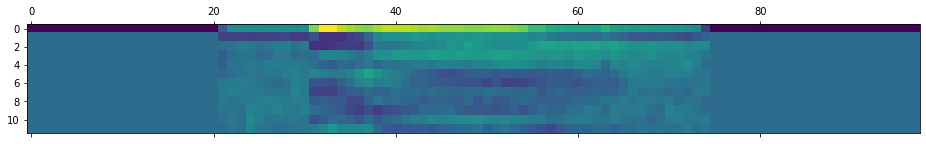

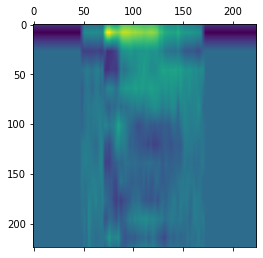

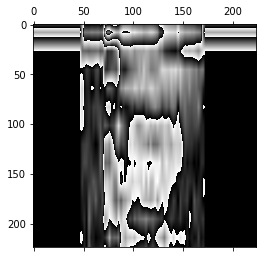

In [34]:
from PIL import Image

mfc = pipeline(signal)
print(mfc.shape)

mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
print(mfc_3d.shape)  
# a pre-trained ResNet-34 uses an input shape of 3 (channel) * 224 * 244
# however, in order to save an image in RGB format, its shape has to be 224 * 224 * 3
# during model training, reshaping images from 224 * 224 * 3 to 3 * 224 * 224 will be taken care of

# mfc_img = scipy.misc.toimage(mfc_3d, cmin=0, cmax=255)
mfc_img = Image.fromarray(mfc_3d.astype('uint8'))
print(np.array(mfc_img).max(), np.array(mfc_img).min(), np.array(mfc_img).mean())

plt.matshow(mfc)
plt.matshow(mfc_3d[:,:,2])  # the second channel; the first and the third channel look exactly the same
plt.matshow(mfc_img)
plt.show()

## Output MFC JPEGs

### Define target dir

In [47]:
dataset_dir = '../mfc_dataset_v2'

### For male

Create a one-to-one mapping between MFC JPEG names and WAV names. This dictionary will be used in model evaluation.

In [48]:
# male_idxs_to_wav_fpaths = {}
# for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
#     male_idxs_to_wav_fpaths[f'{dataset_dir}/male_{i}.jpg'] = fp


# from tqdm import tqdm_notebook

# male_idxs_to_wav_fpaths = {}
# for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
#     male_idxs_to_wav_fpaths[f'{dataset_dir}/male_{i}.jpg'] = fp

from tqdm import tqdm

male_idxs_to_wav_fpaths = {}
for i, fp in tqdm(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    male_idxs_to_wav_fpaths[f'{dataset_dir}/male_{i}.jpg'] = fp


100%|██████████████████████████████████████████████████████████████████████| 24000/24000 [00:00<00:00, 692605.59it/s]


In [49]:
with open('../maps/male_idxs_to_wav_fpaths_toan.json', 'w+') as json_f:
    json.dump(male_idxs_to_wav_fpaths, json_f)

Generate MPC JPEGs.

In [64]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import scipy.io.wavfile

np.random.seed(1)  # determine how pad_signal pads signals
for i, fp in tqdm(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))

    # Ensure values are in the range [0, 255]
    mfc_img = (mfc_3d - mfc_3d.min()) / (mfc_3d.max() - mfc_3d.min()) * 255
    mfc_img = mfc_img.astype('uint8')

    # Set background pixels to 0 (black)
    mfc_img[mfc_3d == 0] = 0

    # Create a PIL Image from the array
    mfc_pil = Image.fromarray(mfc_img)

    # Save the image using PIL
    mfc_pil.save(f'{dataset_dir}/male_{i}.jpg')



100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [11:09<00:00, 35.82it/s]


### For female

<div style="text-align: justify">
Create a one-to-one mapping between MFC JPEG names and WAV names. This dictionary will be used in model evaluation.
</div>

In [66]:
female_idxs_to_wav_fpaths = {}
for i, fp in tqdm(enumerate(female_wav_fpaths), total=len(female_wav_fpaths), desc="Processing Female WAV Files"):
    female_idxs_to_wav_fpaths[f'{dataset_dir}/female_{i}.jpg'] = fp



Processing Female WAV Files: 100%|███████████████████████████████████████████| 6000/6000 [00:00<00:00, 424074.01it/s]


In [67]:
with open('../maps/female_idxs_to_wav_fpaths_toan.json', 'w+') as json_f:
    json.dump(female_idxs_to_wav_fpaths, json_f)

Generate MPC JPEGs.

In [70]:
# np.random.seed(2)  # determine how pad_signal pad signals
# for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
#     _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
#     signal = pad_signal(signal, target_len=max_samples)
#     mfc = pipeline(signal)
#     mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
#     scipy.misc.toimage(mfc_3d, cmin=0, cmax=255).save(f'{dataset_dir}/female_{i}.jpg')

from PIL import Image

np.random.seed(2)  # determine how pad_signal pad signals
for i, fp in tqdm(enumerate(female_wav_fpaths), total=len(female_wav_fpaths), desc="Processing Female WAV Files"):
    _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))

    # Ensure values are in the range [0, 255]
    mfc_img = (mfc_3d - mfc_3d.min()) / (mfc_3d.max() - mfc_3d.min()) * 255
    mfc_img = mfc_img.astype('uint8')

    # Create a PIL Image from the array
    mfc_pil = Image.fromarray(mfc_img)

    # Save the image using PIL
    mfc_pil.save(f'{dataset_dir}/female_{i}.jpg')





Processing Female WAV Files:   0%|                                                          | 0/6000 [00:00<?, ?it/s]

Processing Female WAV Files:   0%|                                                  | 4/6000 [00:00<03:00, 33.23it/s]

Processing Female WAV Files:   0%|                                                  | 8/6000 [00:00<02:57, 33.82it/s]

Processing Female WAV Files:   0%|                                                 | 12/6000 [00:00<02:47, 35.75it/s]

Processing Female WAV Files:   0%|▏                                                | 16/6000 [00:00<02:44, 36.36it/s]

Processing Female WAV Files:   0%|▏                                                | 20/6000 [00:00<02:42, 36.88it/s]

Processing Female WAV Files:   0%|▏                                                | 24/6000 [00:00<02:40, 37.20it/s]

Processing Female WAV Files:   0%|▏                                                | 28/6000 [00:00<02:38, 37.57it/s]

Processing Female WAV Files:   1%|▎           

Processing Female WAV Files:   4%|██                                              | 265/6000 [00:07<02:27, 38.77it/s]

Processing Female WAV Files:   4%|██▏                                             | 269/6000 [00:07<02:28, 38.68it/s]

Processing Female WAV Files:   5%|██▏                                             | 273/6000 [00:07<02:26, 38.97it/s]

Processing Female WAV Files:   5%|██▏                                             | 277/6000 [00:07<02:26, 39.13it/s]

Processing Female WAV Files:   5%|██▏                                             | 281/6000 [00:07<02:29, 38.35it/s]

Processing Female WAV Files:   5%|██▎                                             | 285/6000 [00:07<02:30, 37.94it/s]

Processing Female WAV Files:   5%|██▎                                             | 289/6000 [00:07<02:29, 38.12it/s]

Processing Female WAV Files:   5%|██▎                                             | 293/6000 [00:07<02:29, 38.19it/s]

Processing Female WAV Files:   5%|██▍           

Processing Female WAV Files:   9%|████▏                                           | 525/6000 [00:14<02:30, 36.46it/s]

Processing Female WAV Files:   9%|████▏                                           | 529/6000 [00:14<02:33, 35.63it/s]

Processing Female WAV Files:   9%|████▎                                           | 533/6000 [00:14<02:35, 35.05it/s]

Processing Female WAV Files:   9%|████▎                                           | 537/6000 [00:14<02:38, 34.48it/s]

Processing Female WAV Files:   9%|████▎                                           | 541/6000 [00:15<02:37, 34.71it/s]

Processing Female WAV Files:   9%|████▎                                           | 545/6000 [00:15<02:37, 34.72it/s]

Processing Female WAV Files:   9%|████▍                                           | 549/6000 [00:15<02:41, 33.76it/s]

Processing Female WAV Files:   9%|████▍                                           | 553/6000 [00:15<02:42, 33.42it/s]

Processing Female WAV Files:   9%|████▍         

Processing Female WAV Files:  13%|██████▎                                         | 783/6000 [00:22<03:03, 28.46it/s]

Processing Female WAV Files:  13%|██████▎                                         | 787/6000 [00:22<02:54, 29.86it/s]

Processing Female WAV Files:  13%|██████▎                                         | 791/6000 [00:22<02:58, 29.13it/s]

Processing Female WAV Files:  13%|██████▎                                         | 795/6000 [00:22<02:49, 30.65it/s]

Processing Female WAV Files:  13%|██████▍                                         | 799/6000 [00:22<02:43, 31.73it/s]

Processing Female WAV Files:  13%|██████▍                                         | 803/6000 [00:22<02:38, 32.73it/s]

Processing Female WAV Files:  13%|██████▍                                         | 807/6000 [00:22<02:36, 33.22it/s]

Processing Female WAV Files:  14%|██████▍                                         | 811/6000 [00:23<02:35, 33.38it/s]

Processing Female WAV Files:  14%|██████▌       

Processing Female WAV Files:  17%|████████▏                                      | 1043/6000 [00:29<02:27, 33.58it/s]

Processing Female WAV Files:  17%|████████▏                                      | 1047/6000 [00:29<02:26, 33.80it/s]

Processing Female WAV Files:  18%|████████▏                                      | 1051/6000 [00:29<02:23, 34.46it/s]

Processing Female WAV Files:  18%|████████▎                                      | 1055/6000 [00:29<02:22, 34.72it/s]

Processing Female WAV Files:  18%|████████▎                                      | 1059/6000 [00:30<02:20, 35.13it/s]

Processing Female WAV Files:  18%|████████▎                                      | 1063/6000 [00:30<02:28, 33.22it/s]

Processing Female WAV Files:  18%|████████▎                                      | 1067/6000 [00:30<02:26, 33.78it/s]

Processing Female WAV Files:  18%|████████▍                                      | 1071/6000 [00:30<02:27, 33.39it/s]

Processing Female WAV Files:  18%|████████▍     

Processing Female WAV Files:  22%|██████████▏                                    | 1303/6000 [00:37<02:20, 33.32it/s]

Processing Female WAV Files:  22%|██████████▏                                    | 1307/6000 [00:37<02:20, 33.45it/s]

Processing Female WAV Files:  22%|██████████▎                                    | 1311/6000 [00:37<02:19, 33.68it/s]

Processing Female WAV Files:  22%|██████████▎                                    | 1315/6000 [00:37<02:18, 33.86it/s]

Processing Female WAV Files:  22%|██████████▎                                    | 1319/6000 [00:37<02:18, 33.69it/s]

Processing Female WAV Files:  22%|██████████▎                                    | 1323/6000 [00:37<02:14, 34.68it/s]

Processing Female WAV Files:  22%|██████████▍                                    | 1327/6000 [00:37<02:11, 35.51it/s]

Processing Female WAV Files:  22%|██████████▍                                    | 1331/6000 [00:37<02:10, 35.67it/s]

Processing Female WAV Files:  22%|██████████▍   

Processing Female WAV Files:  26%|████████████▏                                  | 1563/6000 [00:44<02:10, 34.03it/s]

Processing Female WAV Files:  26%|████████████▎                                  | 1567/6000 [00:44<02:08, 34.56it/s]

Processing Female WAV Files:  26%|████████████▎                                  | 1571/6000 [00:45<02:05, 35.24it/s]

Processing Female WAV Files:  26%|████████████▎                                  | 1575/6000 [00:45<02:05, 35.13it/s]

Processing Female WAV Files:  26%|████████████▎                                  | 1579/6000 [00:45<02:04, 35.39it/s]

Processing Female WAV Files:  26%|████████████▍                                  | 1583/6000 [00:45<02:07, 34.63it/s]

Processing Female WAV Files:  26%|████████████▍                                  | 1587/6000 [00:45<02:12, 33.42it/s]

Processing Female WAV Files:  27%|████████████▍                                  | 1591/6000 [00:45<02:16, 32.21it/s]

Processing Female WAV Files:  27%|████████████▍ 

Processing Female WAV Files:  30%|██████████████▎                                | 1820/6000 [00:52<01:57, 35.66it/s]

Processing Female WAV Files:  30%|██████████████▎                                | 1824/6000 [00:52<01:58, 35.16it/s]

Processing Female WAV Files:  30%|██████████████▎                                | 1828/6000 [00:53<01:59, 34.90it/s]

Processing Female WAV Files:  31%|██████████████▎                                | 1832/6000 [00:53<01:59, 34.80it/s]

Processing Female WAV Files:  31%|██████████████▍                                | 1836/6000 [00:53<01:59, 34.95it/s]

Processing Female WAV Files:  31%|██████████████▍                                | 1840/6000 [00:53<01:57, 35.38it/s]

Processing Female WAV Files:  31%|██████████████▍                                | 1844/6000 [00:53<01:57, 35.30it/s]

Processing Female WAV Files:  31%|██████████████▍                                | 1848/6000 [00:53<01:57, 35.24it/s]

Processing Female WAV Files:  31%|██████████████

Processing Female WAV Files:  35%|████████████████▎                              | 2078/6000 [01:00<01:57, 33.44it/s]

Processing Female WAV Files:  35%|████████████████▎                              | 2082/6000 [01:01<01:59, 32.77it/s]

Processing Female WAV Files:  35%|████████████████▎                              | 2086/6000 [01:01<02:00, 32.57it/s]

Processing Female WAV Files:  35%|████████████████▎                              | 2090/6000 [01:01<01:58, 33.10it/s]

Processing Female WAV Files:  35%|████████████████▍                              | 2094/6000 [01:01<01:56, 33.55it/s]

Processing Female WAV Files:  35%|████████████████▍                              | 2098/6000 [01:01<01:54, 34.07it/s]

Processing Female WAV Files:  35%|████████████████▍                              | 2102/6000 [01:01<01:53, 34.32it/s]

Processing Female WAV Files:  35%|████████████████▍                              | 2106/6000 [01:01<01:51, 34.78it/s]

Processing Female WAV Files:  35%|██████████████

Processing Female WAV Files:  39%|██████████████████▎                            | 2338/6000 [01:08<01:57, 31.27it/s]

Processing Female WAV Files:  39%|██████████████████▎                            | 2342/6000 [01:08<01:53, 32.15it/s]

Processing Female WAV Files:  39%|██████████████████▍                            | 2346/6000 [01:08<01:51, 32.69it/s]

Processing Female WAV Files:  39%|██████████████████▍                            | 2350/6000 [01:08<01:50, 32.96it/s]

Processing Female WAV Files:  39%|██████████████████▍                            | 2354/6000 [01:08<01:48, 33.51it/s]

Processing Female WAV Files:  39%|██████████████████▍                            | 2358/6000 [01:09<01:49, 33.36it/s]

Processing Female WAV Files:  39%|██████████████████▌                            | 2362/6000 [01:09<01:47, 33.76it/s]

Processing Female WAV Files:  39%|██████████████████▌                            | 2366/6000 [01:09<01:46, 34.26it/s]

Processing Female WAV Files:  40%|██████████████

Processing Female WAV Files:  43%|████████████████████▎                          | 2598/6000 [01:16<01:38, 34.43it/s]

Processing Female WAV Files:  43%|████████████████████▍                          | 2602/6000 [01:16<01:37, 34.81it/s]

Processing Female WAV Files:  43%|████████████████████▍                          | 2606/6000 [01:16<01:36, 35.18it/s]

Processing Female WAV Files:  44%|████████████████████▍                          | 2610/6000 [01:16<01:36, 35.23it/s]

Processing Female WAV Files:  44%|████████████████████▍                          | 2614/6000 [01:16<01:36, 35.14it/s]

Processing Female WAV Files:  44%|████████████████████▌                          | 2618/6000 [01:16<01:35, 35.28it/s]

Processing Female WAV Files:  44%|████████████████████▌                          | 2622/6000 [01:16<01:36, 34.94it/s]

Processing Female WAV Files:  44%|████████████████████▌                          | 2626/6000 [01:17<01:36, 34.99it/s]

Processing Female WAV Files:  44%|██████████████

Processing Female WAV Files:  48%|██████████████████████▍                        | 2858/6000 [01:23<01:28, 35.68it/s]

Processing Female WAV Files:  48%|██████████████████████▍                        | 2862/6000 [01:23<01:27, 35.90it/s]

Processing Female WAV Files:  48%|██████████████████████▍                        | 2866/6000 [01:23<01:26, 36.12it/s]

Processing Female WAV Files:  48%|██████████████████████▍                        | 2870/6000 [01:23<01:26, 36.21it/s]

Processing Female WAV Files:  48%|██████████████████████▌                        | 2874/6000 [01:24<01:28, 35.40it/s]

Processing Female WAV Files:  48%|██████████████████████▌                        | 2878/6000 [01:24<01:27, 35.56it/s]

Processing Female WAV Files:  48%|██████████████████████▌                        | 2882/6000 [01:24<01:27, 35.62it/s]

Processing Female WAV Files:  48%|██████████████████████▌                        | 2886/6000 [01:24<01:27, 35.78it/s]

Processing Female WAV Files:  48%|██████████████

Processing Female WAV Files:  52%|████████████████████████▍                      | 3118/6000 [01:30<01:19, 36.36it/s]

Processing Female WAV Files:  52%|████████████████████████▍                      | 3122/6000 [01:31<01:18, 36.50it/s]

Processing Female WAV Files:  52%|████████████████████████▍                      | 3126/6000 [01:31<01:19, 36.35it/s]

Processing Female WAV Files:  52%|████████████████████████▌                      | 3130/6000 [01:31<01:18, 36.59it/s]

Processing Female WAV Files:  52%|████████████████████████▌                      | 3134/6000 [01:31<01:17, 36.78it/s]

Processing Female WAV Files:  52%|████████████████████████▌                      | 3138/6000 [01:31<01:17, 36.80it/s]

Processing Female WAV Files:  52%|████████████████████████▌                      | 3142/6000 [01:31<01:19, 36.00it/s]

Processing Female WAV Files:  52%|████████████████████████▋                      | 3146/6000 [01:31<01:19, 36.02it/s]

Processing Female WAV Files:  52%|██████████████

Processing Female WAV Files:  56%|██████████████████████████▍                    | 3378/6000 [01:38<01:11, 36.62it/s]

Processing Female WAV Files:  56%|██████████████████████████▍                    | 3382/6000 [01:38<01:11, 36.46it/s]

Processing Female WAV Files:  56%|██████████████████████████▌                    | 3386/6000 [01:38<01:10, 36.82it/s]

Processing Female WAV Files:  56%|██████████████████████████▌                    | 3390/6000 [01:38<01:10, 37.12it/s]

Processing Female WAV Files:  57%|██████████████████████████▌                    | 3394/6000 [01:38<01:09, 37.32it/s]

Processing Female WAV Files:  57%|██████████████████████████▌                    | 3398/6000 [01:38<01:09, 37.37it/s]

Processing Female WAV Files:  57%|██████████████████████████▋                    | 3402/6000 [01:38<01:10, 37.00it/s]

Processing Female WAV Files:  57%|██████████████████████████▋                    | 3406/6000 [01:38<01:10, 36.75it/s]

Processing Female WAV Files:  57%|██████████████

Processing Female WAV Files:  61%|████████████████████████████▍                  | 3638/6000 [01:45<01:04, 36.42it/s]

Processing Female WAV Files:  61%|████████████████████████████▌                  | 3642/6000 [01:45<01:04, 36.38it/s]

Processing Female WAV Files:  61%|████████████████████████████▌                  | 3646/6000 [01:45<01:04, 36.51it/s]

Processing Female WAV Files:  61%|████████████████████████████▌                  | 3650/6000 [01:45<01:04, 36.16it/s]

Processing Female WAV Files:  61%|████████████████████████████▌                  | 3654/6000 [01:45<01:05, 35.90it/s]

Processing Female WAV Files:  61%|████████████████████████████▋                  | 3658/6000 [01:45<01:05, 35.93it/s]

Processing Female WAV Files:  61%|████████████████████████████▋                  | 3662/6000 [01:46<01:05, 35.76it/s]

Processing Female WAV Files:  61%|████████████████████████████▋                  | 3666/6000 [01:46<01:04, 36.02it/s]

Processing Female WAV Files:  61%|██████████████

Processing Female WAV Files:  65%|██████████████████████████████▌                | 3898/6000 [01:52<00:58, 36.08it/s]

Processing Female WAV Files:  65%|██████████████████████████████▌                | 3902/6000 [01:52<00:58, 36.08it/s]

Processing Female WAV Files:  65%|██████████████████████████████▌                | 3906/6000 [01:53<00:58, 36.08it/s]

Processing Female WAV Files:  65%|██████████████████████████████▋                | 3910/6000 [01:53<00:57, 36.14it/s]

Processing Female WAV Files:  65%|██████████████████████████████▋                | 3914/6000 [01:53<00:57, 36.41it/s]

Processing Female WAV Files:  65%|██████████████████████████████▋                | 3918/6000 [01:53<00:57, 36.32it/s]

Processing Female WAV Files:  65%|██████████████████████████████▋                | 3922/6000 [01:53<00:58, 35.64it/s]

Processing Female WAV Files:  65%|██████████████████████████████▊                | 3926/6000 [01:53<00:59, 34.90it/s]

Processing Female WAV Files:  66%|██████████████

Processing Female WAV Files:  69%|████████████████████████████████▌              | 4158/6000 [02:00<00:51, 36.05it/s]

Processing Female WAV Files:  69%|████████████████████████████████▌              | 4162/6000 [02:00<00:51, 35.88it/s]

Processing Female WAV Files:  69%|████████████████████████████████▋              | 4166/6000 [02:00<00:50, 36.02it/s]

Processing Female WAV Files:  70%|████████████████████████████████▋              | 4170/6000 [02:00<00:52, 35.11it/s]

Processing Female WAV Files:  70%|████████████████████████████████▋              | 4174/6000 [02:00<00:52, 34.85it/s]

Processing Female WAV Files:  70%|████████████████████████████████▋              | 4178/6000 [02:00<00:51, 35.05it/s]

Processing Female WAV Files:  70%|████████████████████████████████▊              | 4182/6000 [02:00<00:53, 33.85it/s]

Processing Female WAV Files:  70%|████████████████████████████████▊              | 4186/6000 [02:00<00:55, 32.94it/s]

Processing Female WAV Files:  70%|██████████████

Processing Female WAV Files:  73%|██████████████████████████████████▌            | 4408/6000 [02:08<00:50, 31.46it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▌            | 4412/6000 [02:08<00:49, 31.88it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▌            | 4416/6000 [02:08<00:48, 32.44it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▌            | 4420/6000 [02:08<00:48, 32.65it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▋            | 4424/6000 [02:08<00:48, 32.28it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▋            | 4428/6000 [02:08<00:48, 32.34it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▋            | 4432/6000 [02:08<00:48, 32.28it/s]

Processing Female WAV Files:  74%|██████████████████████████████████▋            | 4436/6000 [02:08<00:49, 31.46it/s]

Processing Female WAV Files:  74%|██████████████

Processing Female WAV Files:  78%|████████████████████████████████████▌          | 4667/6000 [02:15<00:37, 35.90it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▌          | 4671/6000 [02:15<00:36, 36.01it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▌          | 4675/6000 [02:15<00:38, 34.76it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▋          | 4679/6000 [02:15<00:38, 33.92it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▋          | 4683/6000 [02:16<00:38, 34.02it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▋          | 4687/6000 [02:16<00:37, 34.91it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▋          | 4691/6000 [02:16<00:37, 35.36it/s]

Processing Female WAV Files:  78%|████████████████████████████████████▊          | 4695/6000 [02:16<00:37, 35.02it/s]

Processing Female WAV Files:  78%|██████████████

Processing Female WAV Files:  82%|██████████████████████████████████████▌        | 4920/6000 [02:23<00:32, 33.44it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▌        | 4924/6000 [02:23<00:31, 34.37it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▌        | 4928/6000 [02:23<00:30, 35.04it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▋        | 4932/6000 [02:23<00:30, 35.46it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▋        | 4936/6000 [02:23<00:29, 35.78it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▋        | 4940/6000 [02:23<00:29, 36.18it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▋        | 4944/6000 [02:23<00:29, 36.38it/s]

Processing Female WAV Files:  82%|██████████████████████████████████████▊        | 4948/6000 [02:24<00:29, 35.66it/s]

Processing Female WAV Files:  83%|██████████████

Processing Female WAV Files:  86%|████████████████████████████████████████▌      | 5179/6000 [02:31<00:23, 34.65it/s]

Processing Female WAV Files:  86%|████████████████████████████████████████▌      | 5183/6000 [02:31<00:23, 34.71it/s]

Processing Female WAV Files:  86%|████████████████████████████████████████▋      | 5187/6000 [02:31<00:23, 34.75it/s]

Processing Female WAV Files:  87%|████████████████████████████████████████▋      | 5191/6000 [02:31<00:23, 33.87it/s]

Processing Female WAV Files:  87%|████████████████████████████████████████▋      | 5195/6000 [02:31<00:23, 33.66it/s]

Processing Female WAV Files:  87%|████████████████████████████████████████▋      | 5199/6000 [02:31<00:23, 34.35it/s]

Processing Female WAV Files:  87%|████████████████████████████████████████▊      | 5203/6000 [02:32<00:22, 35.03it/s]

Processing Female WAV Files:  87%|████████████████████████████████████████▊      | 5207/6000 [02:32<00:22, 34.50it/s]

Processing Female WAV Files:  87%|██████████████

Processing Female WAV Files:  91%|██████████████████████████████████████████▌    | 5436/6000 [02:39<00:18, 31.28it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▌    | 5440/6000 [02:39<00:17, 32.21it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▋    | 5444/6000 [02:39<00:16, 33.14it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▋    | 5448/6000 [02:39<00:16, 32.91it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▋    | 5452/6000 [02:40<00:17, 32.16it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▋    | 5456/6000 [02:40<00:16, 32.13it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▊    | 5460/6000 [02:40<00:16, 32.06it/s]

Processing Female WAV Files:  91%|██████████████████████████████████████████▊    | 5464/6000 [02:40<00:16, 32.39it/s]

Processing Female WAV Files:  91%|██████████████

Processing Female WAV Files:  95%|████████████████████████████████████████████▌  | 5696/6000 [02:47<00:09, 32.44it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▋  | 5700/6000 [02:47<00:09, 32.66it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▋  | 5704/6000 [02:47<00:08, 32.92it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▋  | 5708/6000 [02:47<00:08, 32.70it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▋  | 5712/6000 [02:47<00:08, 32.77it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▊  | 5716/6000 [02:47<00:08, 32.96it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▊  | 5720/6000 [02:48<00:08, 33.31it/s]

Processing Female WAV Files:  95%|████████████████████████████████████████████▊  | 5724/6000 [02:48<00:08, 33.50it/s]

Processing Female WAV Files:  95%|██████████████

Processing Female WAV Files:  99%|██████████████████████████████████████████████▋| 5956/6000 [02:55<00:01, 33.58it/s]

Processing Female WAV Files:  99%|██████████████████████████████████████████████▋| 5960/6000 [02:55<00:01, 33.84it/s]

Processing Female WAV Files:  99%|██████████████████████████████████████████████▋| 5964/6000 [02:55<00:01, 34.05it/s]

Processing Female WAV Files:  99%|██████████████████████████████████████████████▋| 5968/6000 [02:55<00:00, 34.32it/s]

Processing Female WAV Files: 100%|██████████████████████████████████████████████▊| 5972/6000 [02:55<00:00, 34.60it/s]

Processing Female WAV Files: 100%|██████████████████████████████████████████████▊| 5976/6000 [02:55<00:00, 34.67it/s]

Processing Female WAV Files: 100%|██████████████████████████████████████████████▊| 5980/6000 [02:55<00:00, 35.03it/s]

Processing Female WAV Files: 100%|██████████████████████████████████████████████▊| 5984/6000 [02:55<00:00, 35.24it/s]

Processing Female WAV Files: 100%|██████████████

In [73]:
import os

dataset_dir = '../mfc_dataset_v2' 

male_count = 0
female_count = 0

for filename in os.listdir(dataset_dir):
    if filename.startswith('male_'):
        male_count += 1
    elif filename.startswith('female_'):
        female_count += 1

print(f"Number of male images: {male_count}")
print(f"Number of female images: {female_count}")


Number of male images: 24000
Number of female images: 6000
